In [12]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [13]:
%load_ext autoreload
%autoreload 2
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_class_path, HELMConverter
from node import MolSentenceNode #TODO: change after Filter implementation <- ?
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_path, model_dir, lang_class_path, lang_path = (conf.get(k) for k in ("model_class_path", "model_dir", "lang_class_path", "lang_path"))
lang_class = get_class_from_class_path(lang_class_path)
lang = lang_class.load(repo_root + lang_path)
if lang_class_path.endswith("HELM"): #TODO: should be removed after .lang inclusion
    lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_class_path(model_class_path)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_path, reward_conf = (conf.get(k) for k in ("reward_class_path", "reward_conf"))
reward_class = get_class_from_class_path(reward_class_path)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_path", "policy_conf"))
policy_class = get_class_from_class_path(policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_class_path(s.get("filter_class_path"))
    filters.append(filter_class(**s.get("filter_conf", {})))

Search is started.
0- time: 0.02, count_rollouts: 1, reward: 0.13962196083242204, node: CCN(C)C(=O)N[C@H]1CCC[C@@H](C)C1=O
1- time: 0.12, count_rollouts: 2, reward: 0.21175688847394886, node: O=C(NCc1ccnc2ccccc12)N1CCC1
2- time: 0.40, count_rollouts: 4, reward: 0.15444413537799348, node: c1cccc(CNC(=O)C[NH+]2CCC(OCC3CCCC3)CC2)c1
3- time: 0.70, count_rollouts: 6, reward: -0.008369804546726128, node: [NH3+]Cc1ncc2nccc2o1
4- time: 1.51, count_rollouts: 12, reward: -0.12495352330623145, node: [O-]C(=O)N1CCC[C@@H]1O
5- time: 1.95, count_rollouts: 15, reward: 0.15989603351498452, node: CC(C)N1CC(C[NH2+]C2CCCCC2)CC1
6- time: 2.25, count_rollouts: 17, reward: 0.25351904187532054, node: [O-]c1ccc(F)cc1NC(=O)Nc1cccnc1Cl
7- time: 2.37, count_rollouts: 18, reward: 0.3436116862907363, node: Cc1ccc(OCN2CCN(C(=O)c3ccc(Cl)c(F)c3)CC2)cc1
8- time: 2.55, count_rollouts: 19, reward: 0.005819934288434371, node: [O-]C[C@H]1CCC[C@@H]1C(=O)NC[C@@H]1CCCO1
9- time: 2.85, count_rollouts: 22, reward: 0.3059472716

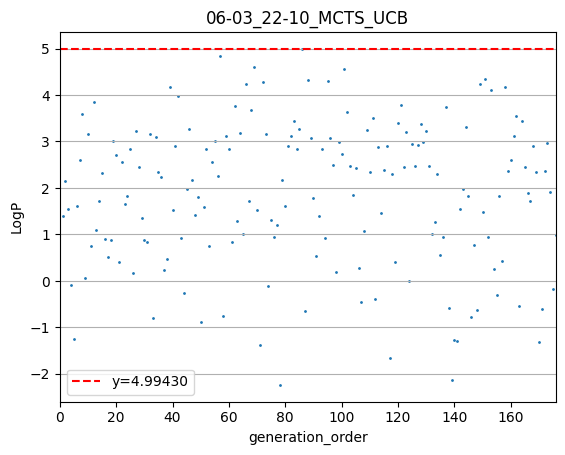

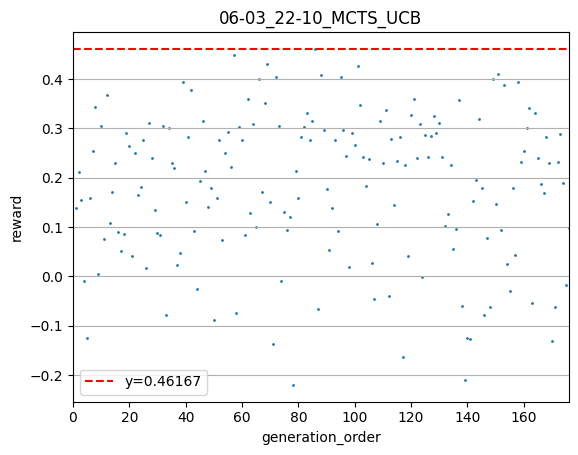

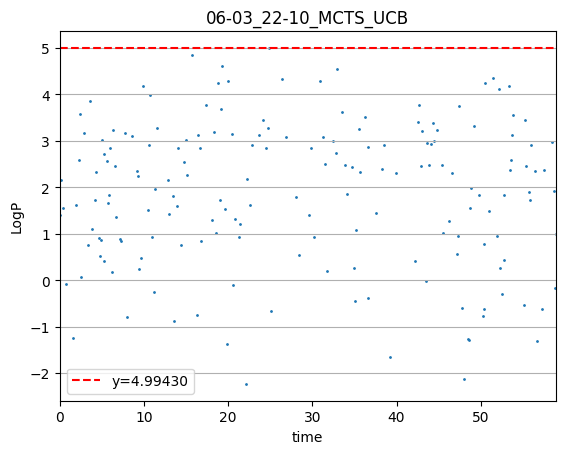

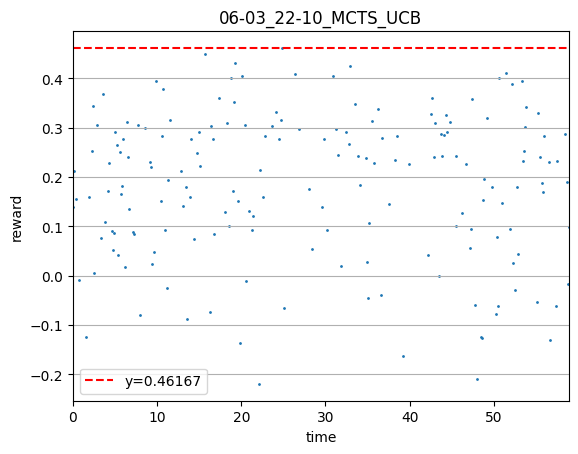

Search is completed.


In [15]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)